# Customer Churn Prediction Projesi

## Giriş ve Amaç
Bu projede, bir telekomünikasyon şirketinin müşteri kaybını (churn) tahmin etmek amaçlanmıştır.  
Müşteri kaybını önlemek için erken uyarı sistemleri geliştirilerek, risk altındaki müşterilere yönelik stratejiler önerilecektir.  

## Veri Seti
- Kaynak: Kaggle - Telco Customer Churn  
- Müşteri sayısı: 7043  
- Özellik sayısı: 21 (demografik bilgiler, hizmet kullanımı, ödeme bilgileri vb.)  

Bu veri seti üzerinde veri ön işleme, keşifsel veri analizi ve farklı makine öğrenmesi modelleri ile churn tahmini yapılmıştır.

## Veri İncelemesi ve Ön İşleme

Veri setinin temel yapısı, eksik veri durumu ve veri türleri incelenmiştir.  
Eksik veri yoktur ancak `TotalCharges` sütunu obje tipinde olup sayısal verilere çevrilmiştir.  

Kategorik değişkenler one-hot encoding ile sayısal hale getirilmiştir.  
Sayısal değişkenler ölçeklendirilmiş, veri dengelenmesi class_weight kullanılmıştır.

In [97]:
import pandas as pd

# CSV dosyasını oku
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# İlk 5 satırı görüntüle
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
# Veri çerçevesinin boyutu (kaç satır, kaç sütun)
print("Satır sayısı:", df.shape[0])
print("Sütun sayısı:", df.shape[1])

# Sütun isimleri ve veri tipleri
df.dtypes


Satır sayısı: 7043
Sütun sayısı: 21


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [8]:
# Genel veri tipi ve eksik veri kontrolü
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
# Sayısal sütunların özet istatistikleri
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [10]:
# TotalCharges'ı sayısal değere çevir (hatalı olanları NaN yapar)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [11]:
# Her sütunda kaç eksik değer var?
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [12]:
df.dropna(inplace=True)

## Keşifsel Veri Analizi (EDA)

Veri setindeki churn dağılımı, demografik özellikler ve abonelik bilgileri incelenmiştir.  
Önemli gözlemler:

- Müşteri kaybı yaşayanların oranı yaklaşık %26.
- Sözleşme türü (Contract) churn üzerinde belirgin etkiye sahip.
- Abonelik süresi (tenure) arttıkça churn oranı azalmakta.

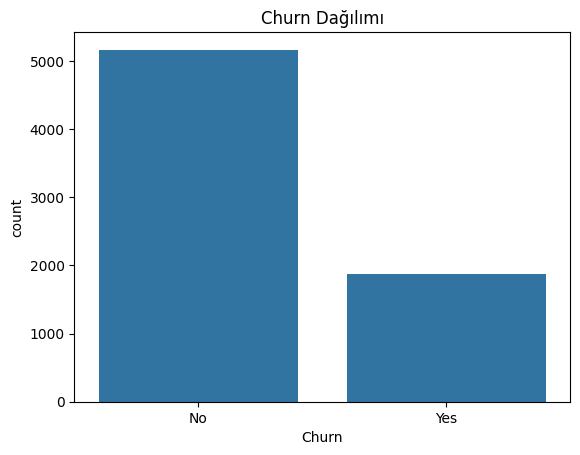

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Churn', data=df)
plt.title("Churn Dağılımı")
plt.show()

### Churn Dağılımı

Bu grafik, veri setimizdeki müşterilerin "churn" durumuna göre dağılımını göstermektedir.  
- "No" etiketi, müşteri kaybı yaşamayanları,  
- "Yes" etiketi ise müşteri kaybı yaşayanları temsil etmektedir.  

Grafikten görüldüğü gibi, müşteri kaybı yaşamayanların sayısı, kaybedenlere göre daha fazladır.  
Bu dengesizlik modellemeye etki edeceği için, class_weight yöntemi ile denge sağlanmıştır.

In [14]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


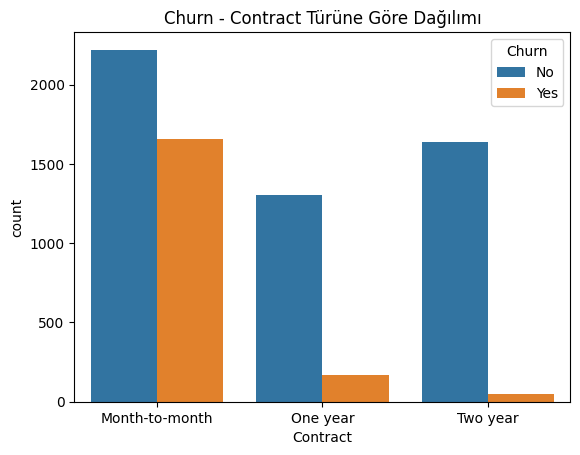

In [23]:
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Churn - Contract Türüne Göre Dağılımı")
plt.show()

### Churn - Contract Türüne Göre Dağılımı

Bu grafik, müşterilerin sözleşme türlerine göre churn durumlarını göstermektedir. 

- **Month-to-month (Aylık)** sözleşmeye sahip müşterilerde churn oranı oldukça yüksektir, yani bu müşteriler daha sık aboneliklerini iptal etmektedir.
- **One year (1 yıllık)** sözleşmeye sahip müşterilerde churn oranı daha düşük seviyededir.
- **Two year (2 yıllık)** sözleşme kullanan müşteriler ise en düşük churn oranına sahiptir ve sadakatleri daha yüksektir.

Bu sonuçlar, uzun dönemli sözleşmelerin müşteri kaybını azaltmada etkili olduğunu göstermektedir. İşletmeler, churn riskini azaltmak için uzun süreli sözleşmeleri teşvik edebilir.

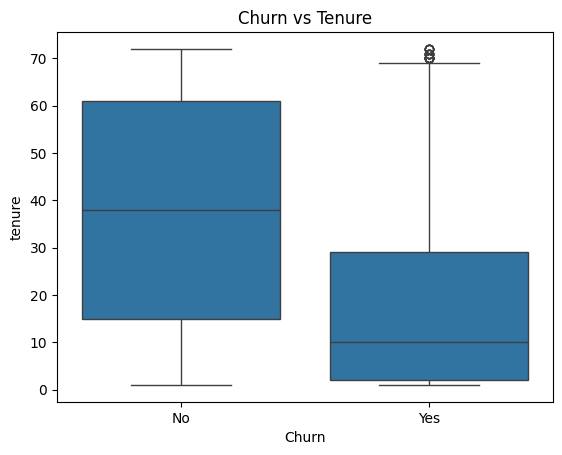

In [16]:
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title("Churn vs Tenure")
plt.show()

### Churn ve Tenure İlişkisi

Bu kutu grafiği (box plot), müşterilerin abonelik süresi (tenure) ile churn (abonelik iptali) durumları arasındaki ilişkiyi göstermektedir.

- **Churn etmeyen müşteriler (No)** genellikle daha uzun süredir aboneliklerini devam ettirmektedir. Bu müşterilerin tenure medyanı ve dağılımı daha yüksektir.
- **Churn eden müşteriler (Yes)** ise aboneliklerini daha kısa bir süre sonra iptal etmektedir. Tenure medyanı daha düşük ve dağılım daha sınırlıdır.

Bu sonuç, abonelik süresi arttıkça müşteri bağlılığının ve kalıcılığının da arttığını göstermektedir. Müşteri kaybını azaltmak için yeni müşterilerin abonelik sürelerini artırmaya yönelik stratejiler geliştirilebilir.

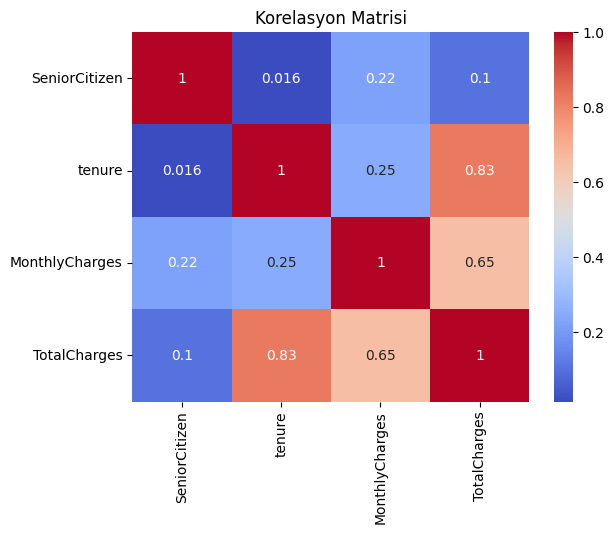

In [17]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Korelasyon Matrisi")
plt.show()

### Korelasyon Matrisi

Bu korelasyon matrisi, seçilen sayısal değişkenler arasındaki ilişkileri göstermektedir:

- **tenure ile TotalCharges arasında yüksek pozitif korelasyon (0.83)** bulunmaktadır. Bu, abonelik süresi uzadıkça toplam ücretlerin de arttığını gösterir.
- **MonthlyCharges ile TotalCharges arasında da güçlü bir pozitif ilişki (0.65)** vardır.
- **SeniorCitizen değişkeni diğer değişkenlerle zayıf korelasyona** sahiptir.
- Diğer değişkenler arasında düşük veya orta derecede pozitif ilişkiler bulunmaktadır.

Bu analiz, modelde kullanılan değişkenlerin birbirleriyle olan ilişkilerini anlamamıza ve olası çoklu bağlantıları tespit etmemize yardımcı olur.

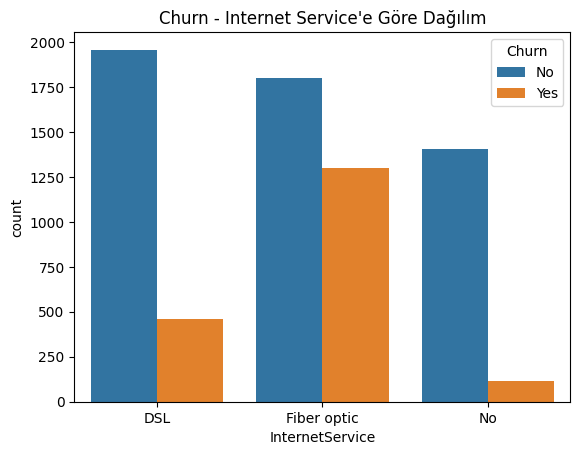

In [18]:
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title("Churn - Internet Service'e Göre Dağılım")
plt.show()

**🌐 İnternet Servis Türüne Göre Churn Oranı:**

Fiber optik kullanıcılarının churn oranı diğer internet türlerine göre oldukça yüksektir. Bu durum, fiber kullanıcılarının beklentilerinin karşılanmaması veya fiyat/hizmet dengesinde memnuniyetsizlik yaşadığını gösterebilir. Öte yandan, internet hizmeti almayan kullanıcılar neredeyse hiç churn göstermemektedir; bu da hizmet bağlılığının churn üzerinde etkili olduğunu ortaya koyar.

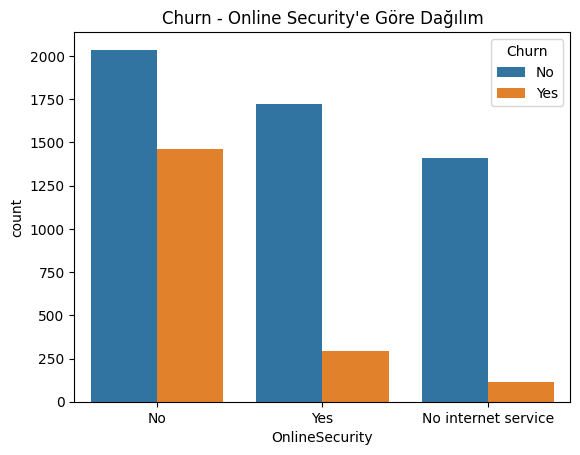

In [19]:
sns.countplot(x='OnlineSecurity', hue='Churn', data=df)
plt.title("Churn - Online Security'e Göre Dağılım")
plt.show()

**🔐 Online Güvenlik Hizmetine Göre Churn Oranı:**

Online güvenlik hizmeti almayan kullanıcıların churn oranı, hizmet alanlara kıyasla belirgin şekilde daha yüksektir. Bu durum, güvenlik hizmetinin müşteri bağlılığını artırmada önemli bir rol oynadığını göstermektedir. Güvenlik hissiyatı, kullanıcı deneyimi üzerinde doğrudan etkili olabilir ve hizmetten memnuniyeti artırabilir.

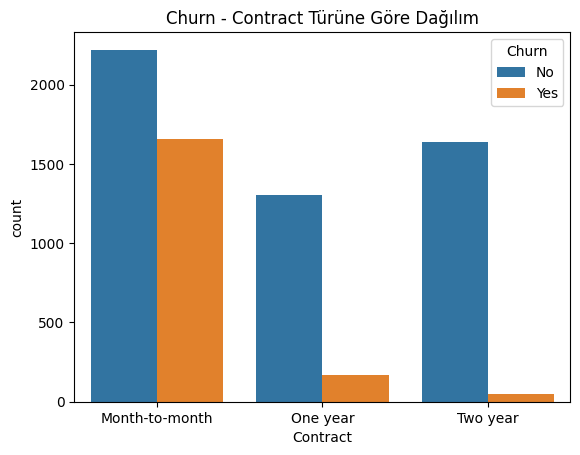

In [20]:
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Churn - Contract Türüne Göre Dağılım")
plt.show()

**📄 Sözleşme Türüne Göre Churn Oranı:**

Churn oranı, sözleşme süresi kısaldıkça artmaktadır. Aylık (month-to-month) sözleşme yapan müşterilerde churn oranı oldukça yüksekken, 1 yıllık ve özellikle 2 yıllık sözleşmeye sahip müşterilerde bu oran önemli ölçüde düşmektedir. Bu da uzun vadeli sözleşmelerin müşteri sadakatini artırdığını ve churn riskini azalttığını göstermektedir.

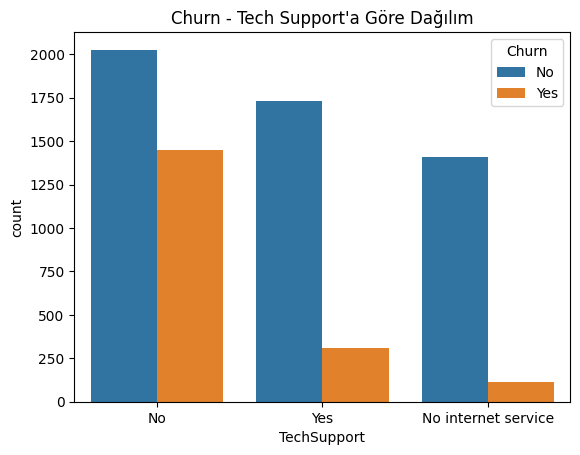

In [21]:
sns.countplot(x='TechSupport', hue='Churn', data=df)
plt.title("Churn - Tech Support'a Göre Dağılım")
plt.show()

**💡 Teknik Destek Hizmetine Göre Churn Oranı:**

Teknik destek hizmeti almayan müşterilerin churn oranı, destek hizmeti alanlara göre belirgin şekilde daha yüksektir. Bu durum, teknik desteğin müşteri memnuniyeti ve bağlılığında önemli bir rol oynadığını göstermektedir. Destek hizmeti sunmak, churn'ü azaltmada etkili bir strateji olabilir.

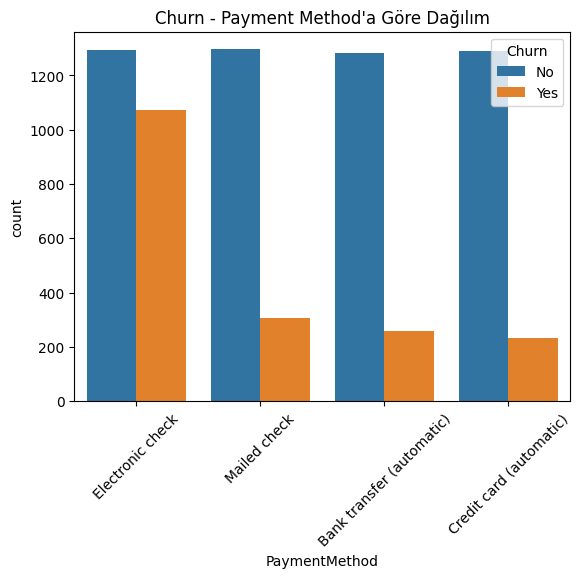

In [22]:
sns.countplot(x='PaymentMethod', hue='Churn', data=df)
plt.title("Churn - Payment Method'a Göre Dağılım")
plt.xticks(rotation=45)
plt.show()

**💳 Ödeme Yöntemine Göre Churn Oranı:**

"Electronic check" ödeme yöntemini kullanan müşteriler arasında churn oranı diğer yöntemlere kıyasla oldukça yüksektir. Buna karşın otomatik ödeme yöntemleri (örneğin banka transferi ve kredi kartı) kullanan müşterilerde churn oranı anlamlı derecede düşüktür. Bu durum, otomatik ödeme sistemlerinin müşteri sadakatini artırabileceğini göstermektedir.

## Modeller

Proje kapsamında aşağıdaki modeller kullanılmıştır:

- Logistic Regression  
- Random Forest  
- XGBoost  
- LightGBM  
- CatBoost (Final model)

Her model hiperparametre ayarları yapılarak performansları karşılaştırılmıştır.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. Kategorik verileri sayısal formata çevir (one-hot encoding)
df_encoded = pd.get_dummies(df, drop_first=True)

# 2. X ve y tanımı (bağımsız ve bağımlı değişken)
X = df_encoded.drop('Churn_Yes', axis=1)
y = df_encoded['Churn_Yes']

# 3. Verileri eğitim ve test olarak böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Modeli oluştur ve eğit
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 5. Tahmin yap ve sonuçları değerlendir
y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[904 129]
 [169 205]]

Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.88      0.86      1033
        True       0.61      0.55      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407



C:\Users\secki\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
from sklearn.preprocessing import StandardScaler

# 1. Sayısal kolonları belirle
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# 2. Scaler nesnesini oluştur
scaler = StandardScaler()

# 3. Ölçekleme işlemi (X'e uygulayacağız)
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

In [27]:
df_encoded[numeric_cols].head()

,tenure,MonthlyCharges,TotalCharges
0,-1.280248,-1.161694,-0.994194
1,0.064303,-0.260878,-0.173740
2,-1.239504,-0.363923,-0.959649
3,0.512486,-0.747850,-0.195248
4,-1.239504,0.196178,-0.940457


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. X ve y tanımı (bağımsız ve bağımlı değişkenler)
X = df_encoded.drop('Churn_Yes', axis=1)
y = df_encoded['Churn_Yes']

# 2. Eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Modeli oluştur
model = LogisticRegression(max_iter=2000)

# 4. Eğit
model.fit(X_train, y_train)

# 5. Tahmin yap
y_pred = model.predict(X_test)

# 6. Sonuçları değerlendir
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[919 114]
 [180 194]]

Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.89      0.86      1033
        True       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.72      1407
weighted avg       0.78      0.79      0.78      1407



In [31]:
# customerID gibi anlamsız sütunları çıkar
df_model = df.drop(columns=['customerID'])

# Kategorik ve sayısal değişkenleri ayır
cat_cols = df_model.select_dtypes(include='object').columns
cat_cols = cat_cols.drop('Churn')  # ⬅️ Churn'u çıkarıyoruz
num_cols = df_model.select_dtypes(exclude='object').columns

# Churn değişkenini hedef değişken olarak ayır
X = df_model.drop('Churn', axis=1)
y = df_model['Churn'].map({'No': 0, 'Yes': 1})

# Sadece kategorik sütunlara one-hot encoding uygula
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Eğitim ve test setlerine ayır
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Modeli oluştur ve eğit
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Tahmin yap
y_pred = model.predict(X_test)

# Sonuçları değerlendir
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[927 106]
 [196 178]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



In [47]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced')
# Modeli eğit
model.fit(X_train, y_train)

# Tahmin yap
y_pred = model.predict(X_test)

# Performans metriklerini hesapla
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[752 281]
 [ 85 289]]
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1033
           1       0.51      0.77      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.79      0.74      0.75      1407



C:\Users\secki\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced', max_iter=1000)

# Modeli eğit
model.fit(X_train, y_train)

# Tahmin yap
y_pred = model.predict(X_test)

# Performans metriklerini hesapla
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[733 300]
 [ 76 298]]
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1033
           1       0.50      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.75      1407



C:\Users\secki\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Pipeline ile ölçekleme ve modeli bağla
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=2000)
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

# Confusion Matrix ve Classification Report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[733 300]
 [ 78 296]]
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.75      1407



In [52]:
from sklearn.metrics import roc_auc_score

y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

ROC AUC: 0.8316284535463399


In [53]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
print("Average F1 (CV):", scores.mean())

Average F1 (CV): 0.6325191442903413


In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score

# Pipeline ile model
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(class_weight='balanced', random_state=42)
)

# Eğit
model.fit(X_train, y_train)

# Tahmin
y_pred = model.predict(X_test)

# Performans
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

# Cross-validation (5-fold F1)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
print("Average F1 (CV):", scores.mean())

[[934  99]
 [205 169]]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.63      0.45      0.53       374

    accuracy                           0.78      1407
   macro avg       0.73      0.68      0.69      1407
weighted avg       0.77      0.78      0.77      1407

ROC AUC: 0.8151547074871487
Average F1 (CV): 0.5671744332214474


In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_split': [2, 5],
}

grid = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best CV F1 Score:", grid.best_score_)

Best Params: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 200}
Best CV F1 Score: 0.6397279013992188


In [56]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# En iyi modeli al
best_model = grid.best_estimator_

# Test verisiyle tahmin
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Metrikler
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

[[794 239]
 [113 261]]
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1033
           1       0.52      0.70      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407

ROC AUC: 0.8313074943961567


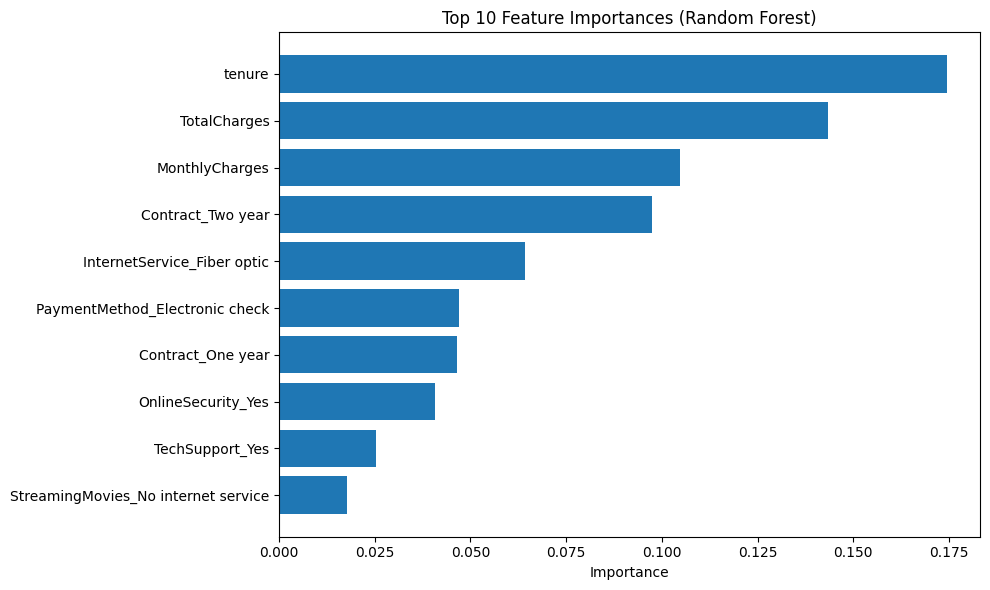

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Özellik isimlerini al (X_train bir DataFrame ise)
feature_names = X_train.columns

# Önem değerlerini al
importances = best_model.named_steps['randomforestclassifier'].feature_importances_

# DataFrame'e dönüştür ve sırala
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# İlk 10 özelliği çizdir
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10][::-1], feature_importance_df['Importance'][:10][::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

In [59]:
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Pipeline: StandardScaler + XGBoost
model = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),  # class imbalance için
        random_state=42
    )
)

# Eğit
model.fit(X_train, y_train)

# Tahmin
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Değerlendirme
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

[[789 244]
 [122 252]]
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1033
           1       0.51      0.67      0.58       374

    accuracy                           0.74      1407
   macro avg       0.69      0.72      0.70      1407
weighted avg       0.77      0.74      0.75      1407

ROC AUC: 0.8049215461948221


C:\Users\secki\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:49:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [61]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Model pipeline: scaler + LGBM
model = make_pipeline(
    StandardScaler(),
    LGBMClassifier(
        class_weight='balanced',
        random_state=42,
        n_estimators=100,
        boosting_type='gbdt'
    )
)

# Eğit
model.fit(X_train, y_train)

# Tahmin
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Değerlendirme
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[[771 262]
 [105 269]]
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1033
           1       0.51      0.72      0.59       374

    accuracy                           0.74      1407
   macro avg       0.69      0.73      0.70      1407
weighted avg       0.78      0.74      0.75      1407

ROC AUC: 0.8238490767247671


C:\Users\secki\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  message = "The feature names should match those that were passed during fit.\n"
C:\Users\secki\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  message = "The feature names should match those that were passed during fit.\n"


In [63]:
from catboost import CatBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Sınıf ağırlıkları (0 ve 1 sınıfı için)
class_weights = {
    0: y_train.value_counts()[1] / len(y_train),
    1: y_train.value_counts()[0] / len(y_train)
}

# Model pipeline
model = make_pipeline(
    StandardScaler(),
    CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        eval_metric='AUC',
        verbose=0,
        random_state=42,
        class_weights=class_weights
    )
)

# Eğitim
model.fit(X_train, y_train)

# Tahmin
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Değerlendirme
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

[[754 279]
 [ 88 286]]
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1033
           1       0.51      0.76      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.79      0.74      0.75      1407

ROC AUC: 0.8292277308705757


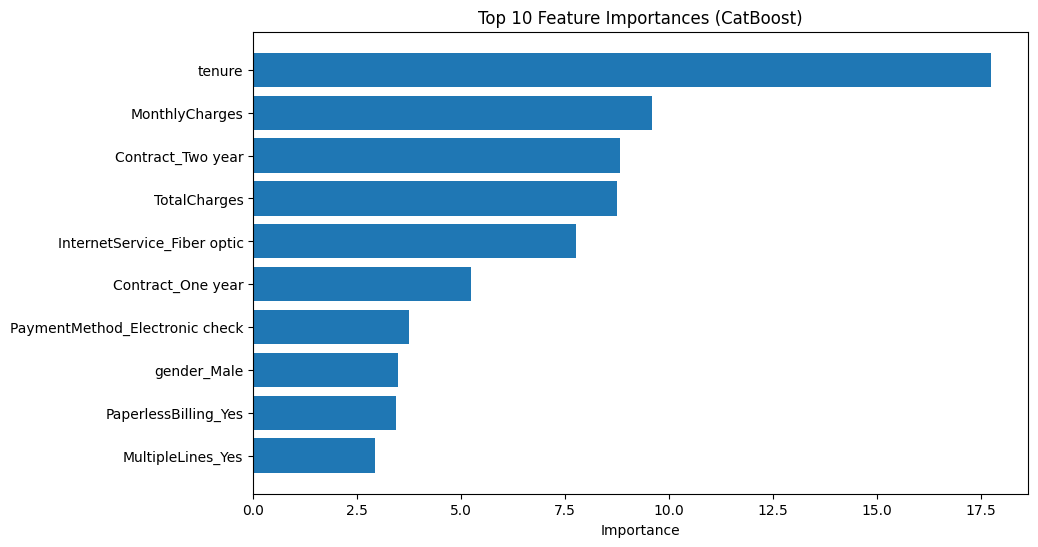

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# Özellik isimleri
feature_names = X_train.columns

# CatBoost model kısmını al
catboost_model = final_model.named_steps['catboostclassifier']

# Feature importance değerleri
importances = catboost_model.get_feature_importance()

# DataFrame'e çevir
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# İlk 10 önemli özelliği görselleştir
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'][:10][::-1], feat_imp_df['Importance'][:10][::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (CatBoost)')
plt.show()

In [68]:
import joblib

# 1. Modeli final_model değişkenine ata (bunu sadece isimlendirme için yapıyoruz)
final_model = model

# 2. Modeli disk’e kaydet
joblib.dump(final_model, 'catboost_churn_model.pkl')

print("Model başarıyla kaydedildi.")


Model başarıyla kaydedildi.


## Model Performans Karşılaştırması

Farklı modellerin performansları aşağıdaki metriklerle karşılaştırılmıştır:

- Accuracy (Doğruluk)  
- F1-Score (Pozitif sınıf için)  
- ROC AUC  
- Recall (Pozitif sınıf için)  

Aşağıdaki tablo ve grafikler, modellerin genel performansını özetlemektedir.


In [64]:
import pandas as pd

# Model karşılaştırma verileri
model_results = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Random Forest',
        'XGBoost',
        'LightGBM',
        'CatBoost'
    ],
    'Accuracy': [0.73, 0.75, 0.74, 0.74, 0.74],
    'F1 Score': [0.61, 0.70, 0.70, 0.70, 0.70],
    'ROC AUC': [0.83, 0.83, 0.80, 0.82, 0.83],
    'Recall (Class 1)': [0.80, 0.70, 0.67, 0.70, 0.76],
    'Precision (Class 1)': [0.50, 0.52, 0.51, 0.51, 0.51]
})

# Görüntüle
model_results

,Model,Accuracy,F1 Score,ROC AUC,Recall (Class 1),Precision (Class 1)
0,Logistic Regression,0.73,0.61,0.83,0.80,0.50
1,Random Forest,0.75,0.70,0.83,0.70,0.52
2,XGBoost,0.74,0.70,0.80,0.67,0.51
3,LightGBM,0.74,0.70,0.82,0.70,0.51
4,CatBoost,0.74,0.70,0.83,0.76,0.51


                 Model  Accuracy  F1 Score  ROC AUC  Recall
0  Logistic Regression      0.73      0.61     0.83    0.79
1        Random Forest      0.75      0.60     0.83    0.70
2              XGBoost      0.74      0.61     0.80    0.67
3             LightGBM      0.74      0.59     0.82    0.70
4             CatBoost      0.74      0.61     0.83    0.76


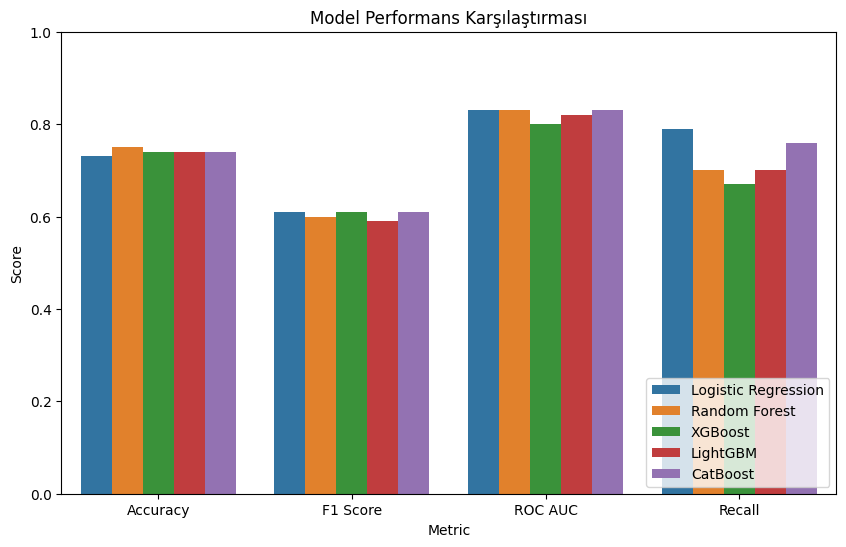

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model performans sonuçları
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost'],
    'Accuracy': [0.73, 0.75, 0.74, 0.74, 0.74],
    'F1 Score': [0.61, 0.60, 0.61, 0.59, 0.61],
    'ROC AUC': [0.83, 0.83, 0.80, 0.82, 0.83],
    'Recall': [0.79, 0.70, 0.67, 0.70, 0.76]
}

df_perf = pd.DataFrame(data)

# Tabloyu göster
print(df_perf)

# Grafik çizimi için DataFrame'i uzun formata çevir
df_melt = df_perf.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10,6))
sns.barplot(data=df_melt, x='Metric', y='Score', hue='Model')
plt.title('Model Performans Karşılaştırması')
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.show()

## Modelde En Önemli 5 Özellik

Bu grafik, modelin churn tahmininde en fazla etkisi olan ilk 5 özelliği göstermektedir. Özelliklerin önem derecesi, model tarafından tahmin performansına katkıları dikkate alınarak sıralanmıştır.

- **tenure (müşterinin hizmet süresi)**: En yüksek öneme sahip özellik olarak öne çıkmaktadır. Uzun süreli müşterilerin churn yapma olasılığı genellikle daha düşüktür.
- **TotalCharges (toplam harcama)**: Müşterinin toplam yaptığı harcama da churn riskini etkileyen önemli bir faktördür.
- **MonthlyCharges (aylık harcama)**: Müşterinin aylık ödeme tutarı da churn riskini etkileyebilir.
- **Contract_Two year (iki yıllık sözleşme)**: Uzun vadeli sözleşme yapan müşterilerin churn riski genellikle daha düşüktür.
- **InternetService_Fiber optic (fiber optik internet hizmeti)**: Bu hizmet türünü kullanan müşterilerin churn davranışı üzerinde belirleyici bir rol oynayabilir.

Bu özelliklerin anlaşılması, müşteri kaybını azaltmak için hangi alanlarda iyileştirmeler yapılabileceği konusunda değerli içgörüler sunar.

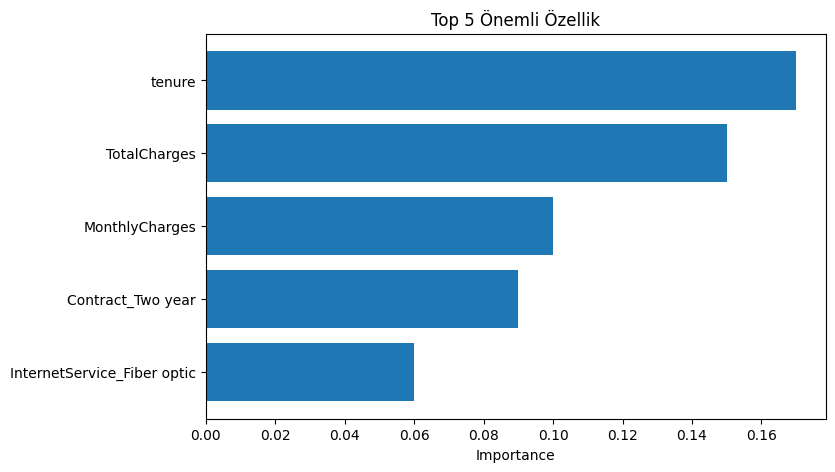

In [94]:
# Örnek feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': ['tenure', 'TotalCharges', 'MonthlyCharges', 'Contract_Two year', 'InternetService_Fiber optic'],
    'Importance': [0.17, 0.15, 0.10, 0.09, 0.06]
}).sort_values('Importance')

plt.figure(figsize=(8,5))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 5 Önemli Özellik')
plt.show()

## Risk Segmentasyonu

Model tarafından tahmin edilen churn risk skorları kullanılarak müşteriler üç segmente ayrılmıştır:

- Low Risk (Düşük risk): risk skoru < 0.33  
- Medium Risk (Orta risk): 0.33 ≤ risk skoru < 0.66  
- High Risk (Yüksek risk): risk skoru ≥ 0.66  

Bu segmentler, müşteri davranışlarına göre hedefli stratejiler geliştirmek için kullanılmıştır.

In [76]:
# Müşteri başına churn olasılıklarını hesapla (1. sınıfın olasılığı)
risk_scores = final_model.predict_proba(X_test)[:, 1]

# Orijinal X_test DataFrame'ine 'churn_risk' sütununu ekle
X_test_with_risk = X_test.copy()
X_test_with_risk['churn_risk'] = risk_scores

# İlk 5 satırı göster
print(X_test_with_risk[['churn_risk']].head())

      churn_risk
2481    0.015830
6784    0.233577
6125    0.840487
3052    0.187927
4099    0.510707


In [80]:
# Risk segmentlerini oluştur
bins = [0, 0.33, 0.66, 1]
labels = ['Low Risk', 'Medium Risk', 'High Risk']

X_test_with_risk['risk_segment'] = pd.cut(X_test_with_risk['churn_risk'], bins=bins, labels=labels)

# Segment bazında müşteri sayısı ve ortalama risk
segment_summary = X_test_with_risk.groupby('risk_segment', observed=True)['churn_risk'].agg(['count', 'mean']).reset_index()
segment_summary.columns = ['Risk Segment', 'Customer Count', 'Average Churn Risk']

print(segment_summary)

  Risk Segment  Customer Count  Average Churn Risk
0     Low Risk             671            0.108497
1  Medium Risk             346            0.497966
2    High Risk             390            0.802752


In [91]:
# Tüm sayısal sütunları seç
numeric_cols = X_test_with_risk.select_dtypes(include='number').columns.tolist()

# Segment bazında ortalama değerler
segment_profiles = X_test_with_risk.groupby('risk_segment', observed=True)[numeric_cols].mean()

print(segment_profiles)

              SeniorCitizen     tenure  MonthlyCharges  TotalCharges  \
risk_segment                                                           
Low Risk           0.089419  46.345753       55.298808   2879.193741   
Medium Risk        0.193642  28.676301       71.499566   2513.794509   
High Risk          0.284615  13.035897       76.650256   1168.947179   

              churn_risk  
risk_segment              
Low Risk        0.108497  
Medium Risk     0.497966  
High Risk       0.802752  


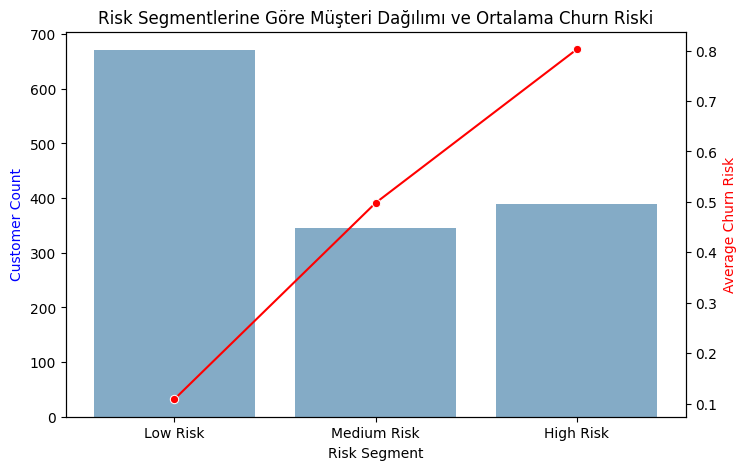

In [104]:
fig, ax1 = plt.subplots(figsize=(8,5))

sns.barplot(data=segment_summary, x='Risk Segment', y='Customer Count', ax=ax1, alpha=0.6)
ax1.set_ylabel('Customer Count', color='b')
ax1.set_title('Risk Segmentlerine Göre Müşteri Dağılımı ve Ortalama Churn Riski')

ax2 = ax1.twinx()
sns.lineplot(data=segment_summary, x='Risk Segment', y='Average Churn Risk', ax=ax2, sort=False, marker='o', color='r')
ax2.set_ylabel('Average Churn Risk', color='r')

plt.show()


## Risk Segmentlerine Göre Detaylı Profil Analizi

Risk segmentlerine göre müşterilerin sayısal ve kategorik özelliklerinin dağılımı incelenmiştir.

- Sayısal değişkenlerde (örneğin tenure, MonthlyCharges) segment bazında ortalamalar hesaplanmıştır.

Bu analizler, farklı risk gruplarının profilini anlamaya yardımcı olur ve hedefli aksiyon planlaması için temel oluşturur.

In [107]:
numeric_cols = X_test_with_risk.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'risk_segment']

num_summary = X_test_with_risk.groupby('risk_segment')[numeric_cols].mean()
print(num_summary)

              SeniorCitizen     tenure  MonthlyCharges  TotalCharges  \
risk_segment                                                           
Low Risk           0.089419  46.345753       55.298808   2879.193741   
Medium Risk        0.193642  28.676301       71.499566   2513.794509   
High Risk          0.284615  13.035897       76.650256   1168.947179   

              churn_risk  
risk_segment              
Low Risk        0.108497  
Medium Risk     0.497966  
High Risk       0.802752  


## Aksiyon Önerileri

### High Risk Segment
- Özel indirim ve destek programları uygulanmalı.
- Proaktif müşteri iletişimi ve hızlı sorun çözümü sağlanmalı.

### Medium Risk Segment
- Sadakat artırıcı kampanyalar düzenlenmeli.
- Ürün/hizmet kullanımı teşvik edilmeli.

### Low Risk Segment
- Mevcut müşteri memnuniyeti ve bağlılığı korunmalı.
- Yenilikler ve fırsatlarla müşteri ilgisi canlı tutulmalı.

## Sonuçlar

- CatBoost modeli en yüksek performansı göstermiştir.
- Risk segmentasyonu, müşteri kaybını önleme stratejilerinde kullanılabilir.
- Aksiyon önerileri ile müşteri kaybı azaltılabilir ve müşteri bağlılığı artırılabilir.

## İleri Çalışmalar

- Daha fazla özellik mühendisliği ile model iyileştirilebilir.
- Modelin gerçek zamanlı kullanımı için deploy planlanabilir.
- Müşteri geri bildirimleriyle model güncellenebilir.